In [23]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, Threshold)
from nipype.interfaces.spm import (Smooth, SliceTiming)
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

from nipype.algorithms.misc import Gunzip

In [24]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [25]:
experiment_dir = '/data/EFAT/EFAT_output_test/PT'
output_dir = 'datasink'
working_dir = 'workingdir'

subject_list = ['001', '003']

task_list = ['EFAT']

un_list = ['01', '02']

fwhm = [8]

TR = 2.0

# Isometric resample of functional images to voxel size (in mm)
iso_size = 2

In [26]:
slice_order = list(range(2, 46, 2)) + list(range(1, 45, 2))
print(slice_order)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43]


In [27]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetime = Node(SliceTiming(num_slices = 44,
                             ref_slice = 22,
                             slice_order = slice_order,
                             time_repetition=2,
                             time_acquisition=2-(2/44)),
                  name="slicetime")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

In [28]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                    name="segmentation", mem_gb=4)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=1,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

In [34]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name', 'un_num']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('un_num', un_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii')
func_file = opj('sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_run-{un_num}_bold.nii')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/EFAT/EFAT_RawData/PT/'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_un_num_', '/run-'),
                 ('asub', 'sub'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par')
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [35]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name'),
                                            ('un_num', 'un_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, slicetime, [('roi_file', 'in_files')]),
                 (slicetime, mcflirt, [('timecorrected_files', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (mcflirt, coregwf, [('out_file', 'applywarp.in_file')]),
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

190123-20:58:54,351 nipype.workflow INFO:
	 Generated workflow graph: /data/EFAT/EFAT_output_test/HC/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


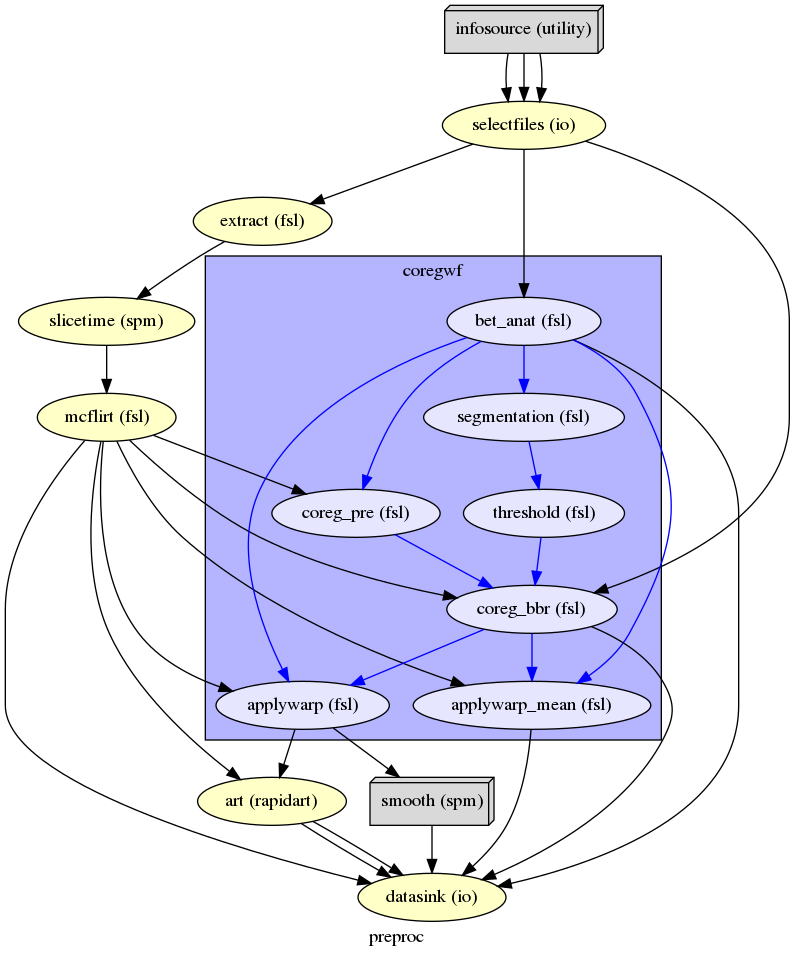

In [36]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

190123-20:58:55,98 nipype.workflow INFO:
	 Generated workflow graph: /data/EFAT/EFAT_output_test/HC/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


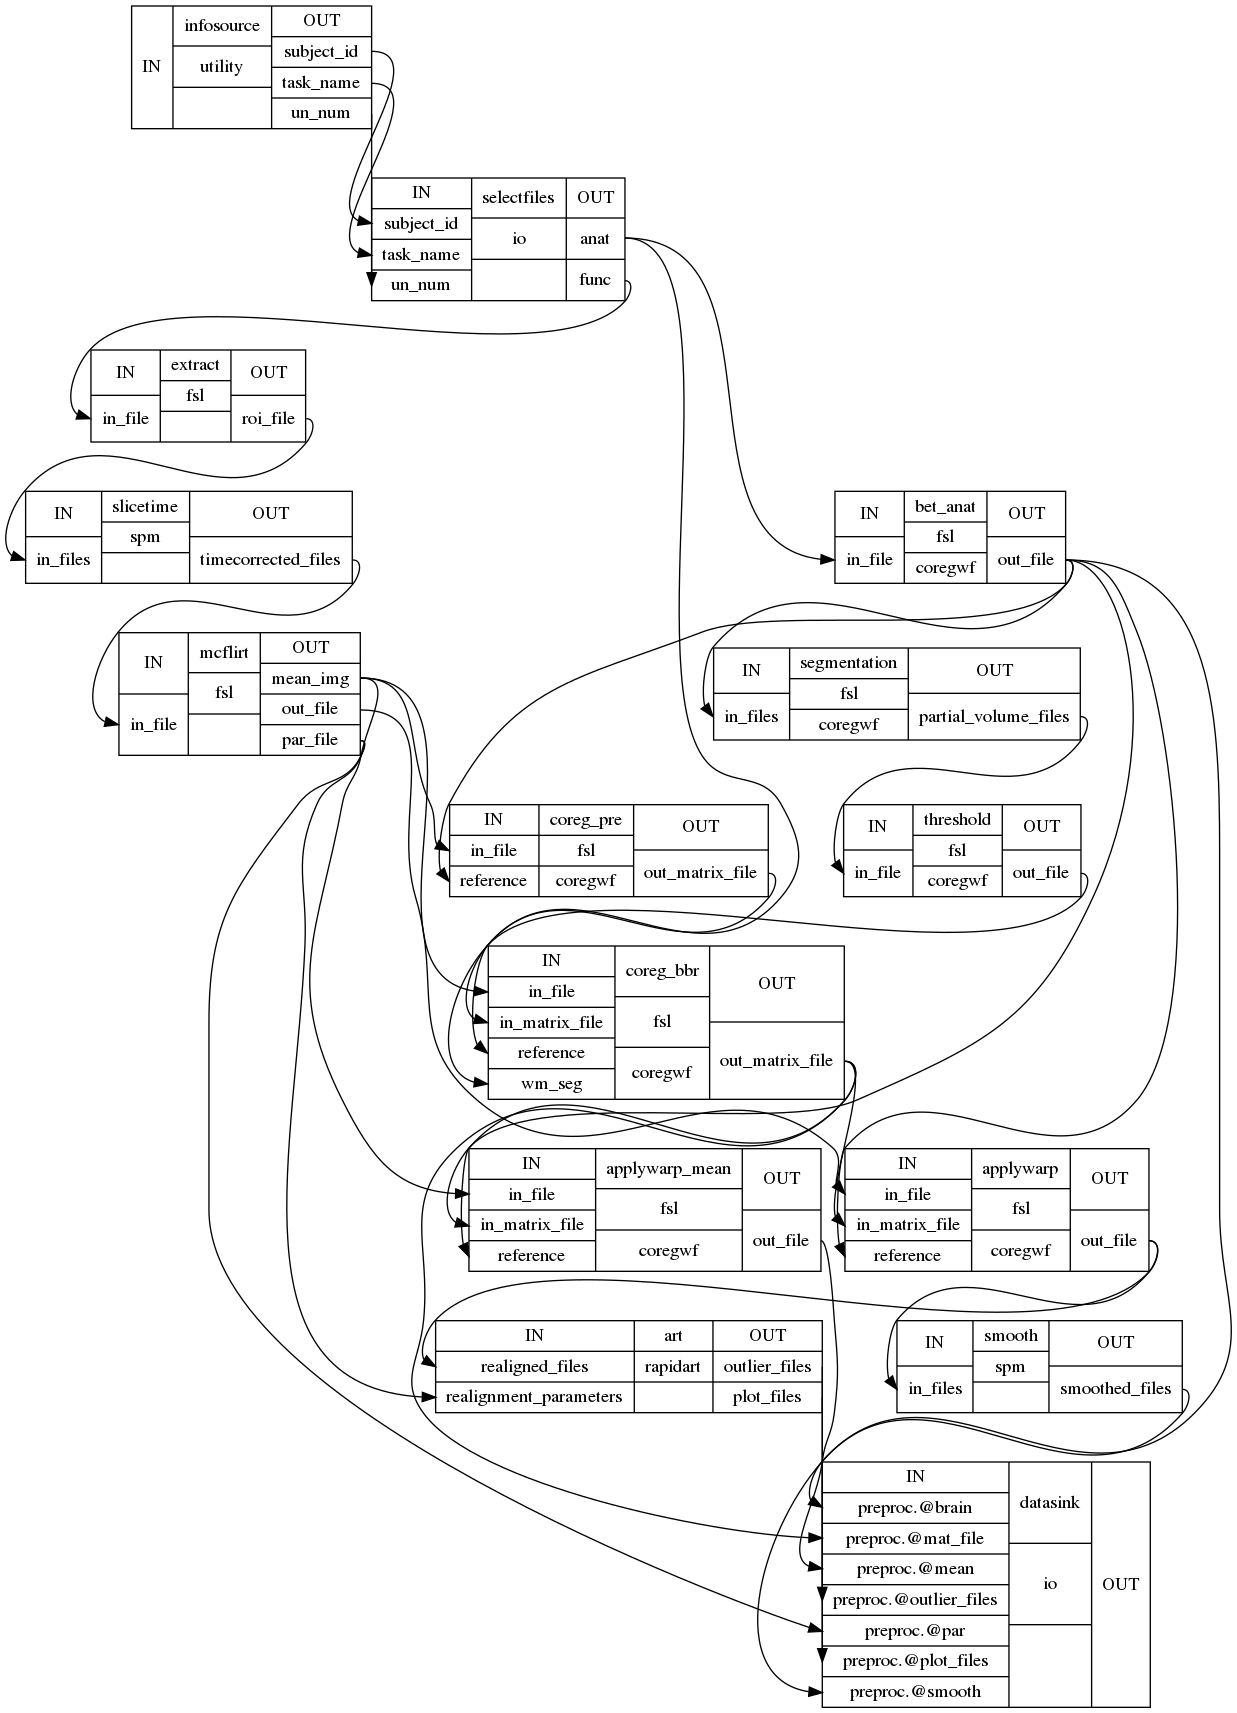

In [37]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [39]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

190123-21:00:16,591 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
190123-21:00:16,668 nipype.workflow INFO:
	 Running in parallel.
190123-21:00:16,676 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 4/4.
190123-21:00:16,822 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/data/EFAT/EFAT_output_test/HC/workingdir/preproc/_subject_id_003_task_name_EFAT_un_num_02/selectfiles".
190123-21:00:16,826 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/data/EFAT/EFAT_output_test/HC/workingdir/preproc/_subject_id_003_task_name_EFAT_un_num_01/selectfiles".
190123-21:00:16,832 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")190123-21:00:16,830 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/data/EFAT/EFAT_output_test/HC/workingdir/preproc/_subject_id_001_task_name_EFAT_un_num

/home/soyeon/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/soyeon/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/soyeon/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/soyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/soyeon/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/soyeon/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, 

190123-21:11:52,698 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
190123-21:11:53,355 nipype.workflow INFO:
	 [Job 12] Completed (preproc.art).
190123-21:11:53,358 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 112.62/113.22, Free processors: 1/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.coreg_bbr
190123-21:11:53,459 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/data/EFAT/EFAT_output_test/HC/workingdir/preproc/_subject_id_003_task_name_EFAT_un_num_01/art".
190123-21:11:53,466 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
190123-21:11:55,359 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 2 jobs ready. Free memory (GB): 112.42/113.22, Free processors: 0/4.
                     Currently running:
                       * preproc.art
                   

/home/soyeon/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/soyeon/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/soyeon/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/soyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/soyeon/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/soyeon/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, 

190123-21:14:10,350 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
190123-21:14:11,490 nipype.workflow INFO:
	 [Job 40] Completed (preproc.art).
190123-21:14:11,495 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 112.82/113.22, Free processors: 2/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.mcflirt
190123-21:14:20,836 nipype.workflow INFO:
	 [Node] Finished "preproc.mcflirt".
190123-21:14:21,500 nipype.workflow INFO:
	 [Job 48] Completed (preproc.mcflirt).
190123-21:14:21,505 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 113.02/113.22, Free processors: 3/4.
                     Currently running:
                       * preproc.smooth
190123-21:14:21,601 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.coreg_pre" in "/data/EFAT/EFAT_output_test/HC/workingdir/preproc/coregwf/_subject_id_001_task_name_EFAT_un_num_01/

In [12]:
from nilearn import image, plotting
out_path = '/data/EFAT/EFAT_output/PT/datasink/preproc/sub-059/task-EFAT'

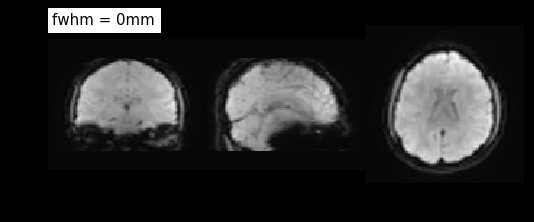

In [13]:
plotting.plot_epi(opj(out_path, 'sub-059_task-EFAT_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

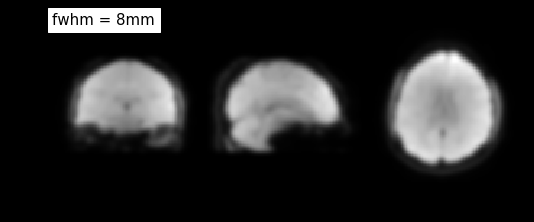

In [14]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-8_ssub-059_task-EFAT_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');